In [1]:
%pylab inline
import torch
import torch.nn.functional as F
import numpy as np
dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

Populating the interactive namespace from numpy and matplotlib


Notes from the [Deep Learning Book](https://www.deeplearningbook.org/)

# Ch.9 Convolutional Networks

### 9.1 The Convolution Operation

$$\renewcommand\vec{\boldsymbol}$$

$$s(t) = \int x(a)w(t-a)da$$

This operation is called **convolution**. The convolution operatot is typically denoted with an asterix:

$$s(t) = (x * w)(t)$$

In convolutional network terminology, the first argument (in this example, the function $x$) to the convolution is often referred to as the **input**, and the second argument (in this example, the function $w$) as the **kernel**. Often $w$ needs to be a valid probability density. The output is sometimes reffered to as the **feature map**.

We often use convolutions over more than one axis at a time. For example, if we use a two-dimensional image $I$ as our input, we probably also want to use a two-dimensional kernel $K$:

$$S(i,j) = (I * K)(i,j) = \sum_m \sum_n I(m,n) ~ K(i - m, j - n)$$

Convolution is commutative, meaning we can equivalently write

$$S(i,j) = (K * I)(i,j) = \sum_m \sum_n I(i - m, j - n) ~ K(m, n)$$

Usually the latter formula is more straightforward to implement.

While the commutative property is useful for writing proofs, it is not usually an important property of a neural network implementation. Instead, many neural network libraries implement a related function called the **cross-correlation**, which is the same as convolution but without flipping the kernel:

$$S(i,j) = (K * I)(i,j) = \sum_m \sum_n I(i + m, j + n) ~ K(m, n)$$

https://www.coursera.org/learn/convolutional-neural-networks/lecture/4Trod/edge-detection-example

In [1]:
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

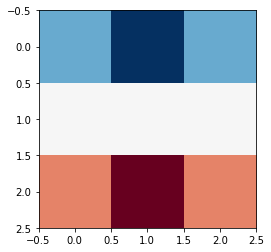

In [16]:
#https://tonysyu.github.io/ipython-jupyter-widgets-an-image-convolution-demo.html#.W6LFW9hKhBw
horizontal_edge_kernel = np.array([[ 1,  2,  1],
                                   [ 0,  0,  0],
                                   [-1, -2, -1]])
plt.imshow(horizontal_edge_kernel, cmap=plt.cm.RdBu);

In [21]:
from skimage import color
from skimage import io

img = color.rgb2gray(io.imread('london.jpg'))

In [22]:
img.shape


(299, 478)

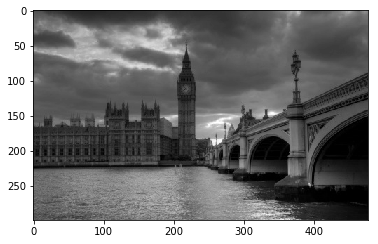

In [23]:
plt.imshow(img);

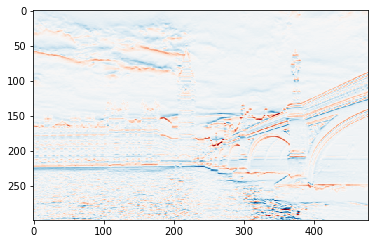

In [24]:
from scipy.ndimage import convolve

horizontal_edge_response = convolve(img, horizontal_edge_kernel)
plt.imshow(horizontal_edge_response, cmap=plt.cm.RdBu);

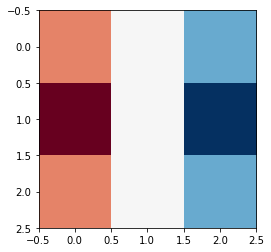

In [27]:
vertical_edge_kernel = np.array([[-1, 0, 1],
                                 [-2, 0, 2],
                                 [-1, 0, 1]])
plt.imshow(vertical_edge_kernel, cmap=plt.cm.RdBu);

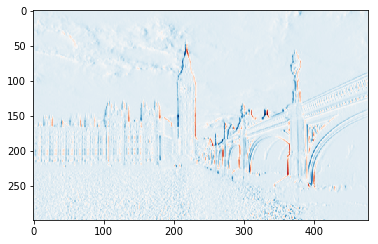

In [28]:
from scipy.ndimage import convolve

vertical_edge_response = convolve(img, vertical_edge_kernel)
plt.imshow(vertical_edge_response, cmap=plt.cm.RdBu);

In [68]:
x = torch.tensor([[[[3,0,1,2,7,4],[1,5,8,9,3,1],[2,7,2,5,1,3],[0,1,3,1,7,8],[4,2,1,6,2,8],[2,4,5,2,3,9]]]], 
                 dtype = dtype)

kernel = torch.tensor([[[[1,0,-1],[1,0,-1],[1,0,-1]]]], dtype= dtype)

torch.nn.functional.conv2d(x, kernel)

tensor([[[[ -5.,  -4.,   0.,   8.],
          [-10.,  -2.,   2.,   3.],
          [  0.,  -2.,  -4.,  -7.],
          [ -3.,  -2.,  -3., -16.]]]])

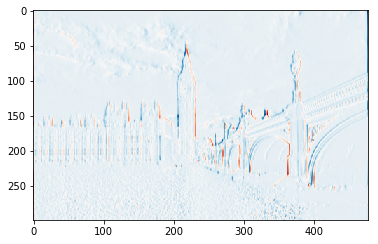

In [76]:
x = torch.tensor([[img]], dtype=dtype)
kernel = torch.tensor([[[[1,0,-1],[1,0,-1],[1,0,-1]]]], dtype= dtype)
x_out = torch.nn.functional.conv2d(x, kernel, padding = 1)
plt.imshow(x_out.tolist()[0][0], cmap=plt.cm.RdBu);

In [77]:
print x.shape
print x_out.shape

torch.Size([1, 1, 299, 478])
torch.Size([1, 1, 299, 478])


# LeNet-5

https://www.coursera.org/learn/convolutional-neural-networks/lecture/MmYe2/classic-networks

http://yann.lecun.com/exdb/mnist/

https://pjreddie.com/projects/mnist-in-csv/

In [23]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

convert("train-images-idx3-ubyte", "train-labels-idx1-ubyte",
        "mnist_train.csv", 60000)
convert("t10k-images-idx3-ubyte", "t10k-labels-idx1-ubyte",
        "mnist_test.csv", 10000)

KeyboardInterrupt: 

In [25]:
import csv
x = list(csv.reader(open("mnist_test.csv").readlines()))
len(x[0])

785

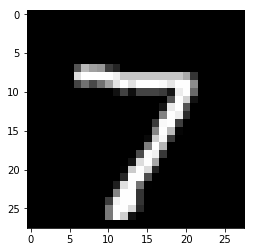

In [27]:
from matplotlib import pyplot as plt
import numpy as np

def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28))).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest')
    return plt

plt.rcParams['image.cmap'] = 'gray'
gen_image(map(int, x[0][1:])).show()

In [51]:
xx = torch.tensor(map(float, x[0][1:])).view(-1, 28)
xx = torch.tensor([[np.reshape(map(float, x[0][1:]), (28, 28))]], dtype = dtype)
xx.shape

torch.Size([1, 1, 28, 28])

In [58]:
kernel = torch.randn(6,1,5,5, device=device, dtype = dtype, requires_grad=True)
x_out = F.conv2d(xx, kernel, padding = 2)
x_out.shape

torch.Size([1, 6, 28, 28])

In [59]:
x_ot = F.max_pool2d(x_out,2, 2)
print x_ot.shape

torch.Size([1, 6, 14, 14])


In [61]:
kernel2 = torch.randn(16,6,5,5, device=device, dtype = dtype, requires_grad=True)
x_out_2 = F.conv2d(x_ot, kernel2, padding = 0)
x_out_2.shape

torch.Size([1, 16, 10, 10])

In [62]:
x_ot_2 = F.max_pool2d(x_out_2,2, 2)
print x_ot_2.shape

torch.Size([1, 16, 5, 5])


In [64]:
x_ot_f = x_ot_2.view(-1, 5*5*16)
x_ot_f.shape

torch.Size([1, 400])

In [72]:
w1 = torch.randn(120, 400, device=device, dtype = dtype, requires_grad=True)
b1 = torch.randn(120, device=device, dtype = dtype, requires_grad=True)
out_fc_1 = F.relu(F.linear(x_ot_f, w1, b1)) 
out_fc_1.shape

torch.Size([1, 120])

In [73]:
w2 = torch.randn(84, 120, device=device, dtype = dtype, requires_grad=True)
b2 = torch.randn(84, device=device, dtype = dtype, requires_grad=True)
out_fc_2 = F.relu(F.linear(out_fc_1, w2, b2))
out_fc_2.shape

torch.Size([1, 84])

In [76]:
w3 = torch.randn(10, 84, device=device, dtype = dtype, requires_grad=True)
b3 = torch.randn(10, device=device, dtype = dtype, requires_grad=True)
out_fc_3 = F.linear(out_fc_2, w3, b3)
out_fc_3.softmax(dim=1)

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward>)

# Neural Transfer

https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

In [40]:
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import copy
import torch.nn as nn
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 256  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("monet.jpg")
content_img = image_loader("venus.jpg")
print style_img.size()
print content_img.size()
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

torch.Size([1, 3, 256, 384])
torch.Size([1, 3, 256, 384])


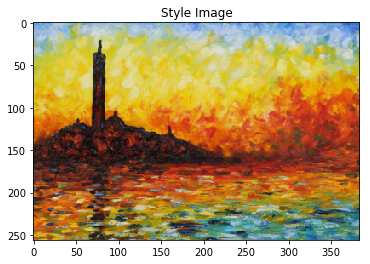

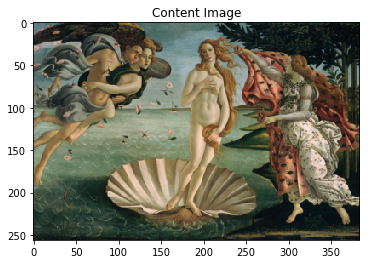

In [41]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [42]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [43]:
# VGG networks are trained on images with each channel normalized by 
# mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. 
# We will use them to normalize the image before sending it into the network.

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(torch.nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [44]:
i = 0  # increment every time we see a conv
for layer in cnn.children():
    if isinstance(layer, torch.nn.Conv2d):
        i += 1
        print i

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [45]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = {'conv_1':torch.FloatTensor([0.1]), 
                        'conv_2':torch.FloatTensor([0.3]), 
                        'conv_3':torch.FloatTensor([1.0]), 
                        'conv_4':torch.FloatTensor([1.5]), 
                        'conv_5':torch.FloatTensor([2.0])}

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = torch.nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, torch.nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, torch.nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, torch.nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, torch.nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        try:
            loss_layer = style_layers[name]
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature, loss_layer)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
        except KeyError:
            pass

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [46]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(torch.nn.Module):

    def __init__(self, target_feature, mul_constant):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.mul_constant = mul_constant

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = torch.mul(self.mul_constant, F.mse_loss(G, self.target))
        return input
    
class ContentLoss(torch.nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [47]:

import torch.optim as optim
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [48]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, content_layer, style_layer,
                       num_steps=300,
                       style_weight=10, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img, content_layer, style_layer)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

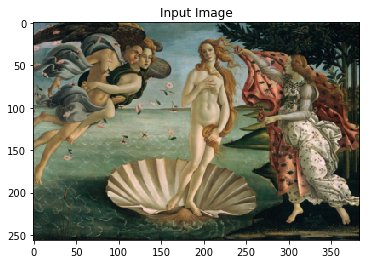

In [49]:
input_img = torch.randn(content_img.data.size(), device=device)
input_img = content_img.clone()
# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [53]:
content_layer = ['conv_4']
style_layer = {'conv_1':torch.FloatTensor([1.1]), 
                'conv_2':torch.FloatTensor([1.2]), 
                'conv_3':torch.FloatTensor([1.3]), 
                'conv_4':torch.FloatTensor([1.4]), 
                'conv_5':torch.FloatTensor([1.5])}

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,
                            content_layer, style_layer,
                            num_steps=600,
                            style_weight=1000000, content_weight=1)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 2.246863 Content Loss: 10.279589
()
run [100]:
Style Loss : 2.169098 Content Loss: 10.095313
()
run [150]:
Style Loss : 2.061163 Content Loss: 9.945522
()
run [200]:
Style Loss : 1.943202 Content Loss: 9.815219
()
run [250]:
Style Loss : 1.816743 Content Loss: 9.702147
()
run [300]:
Style Loss : 1.701436 Content Loss: 9.605991
()
run [350]:
Style Loss : 1.601790 Content Loss: 9.525824
()
run [400]:
Style Loss : 1.518562 Content Loss: 9.450599
()
run [450]:
Style Loss : 1.459173 Content Loss: 9.388906
()
run [500]:
Style Loss : 1.417662 Content Loss: 9.329121
()
run [550]:
Style Loss : 1.385145 Content Loss: 9.279090
()
run [600]:
Style Loss : 1.358182 Content Loss: 9.241563
()


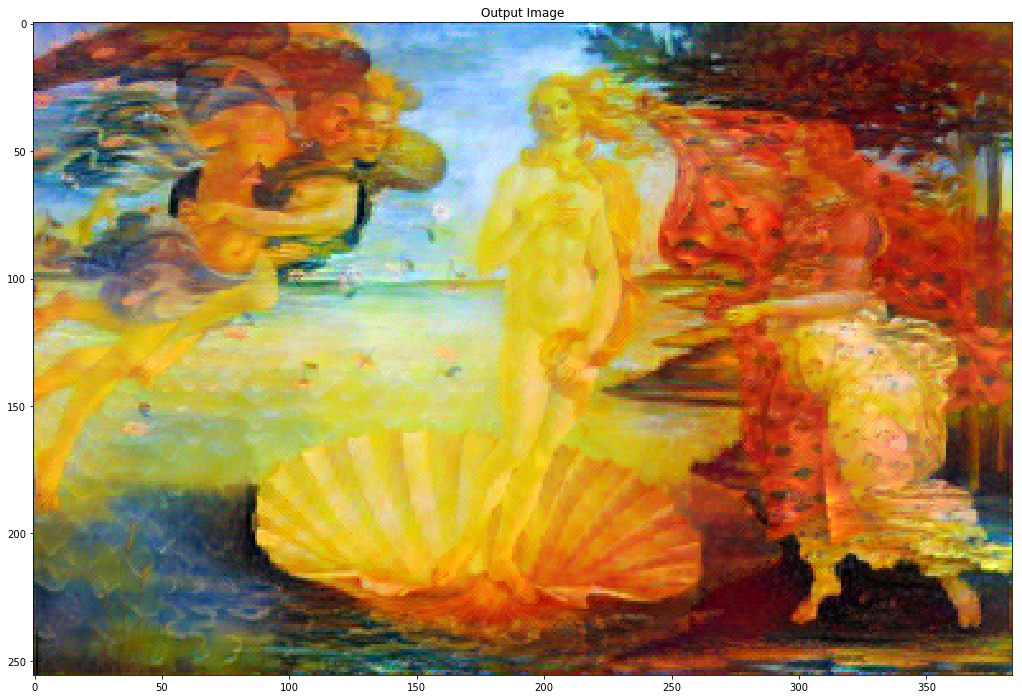

In [55]:
plt.figure(figsize=(18,12))
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()